In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models
from PipelineStages import Loader, ImageProcessing, Labeler, DatasetBuilder, ModelTrainer

2023-07-06 10:09:17.463225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 30ms"
model = models.load_model(path + "/model1.h5")

In [3]:
loader = Loader.Loader(20, 100, path)
stack, tot_loops, info = loader.run()

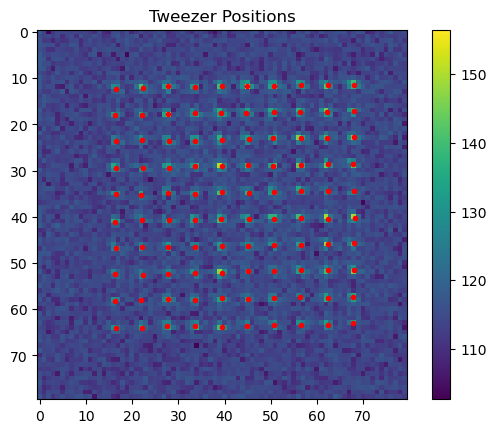

In [4]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

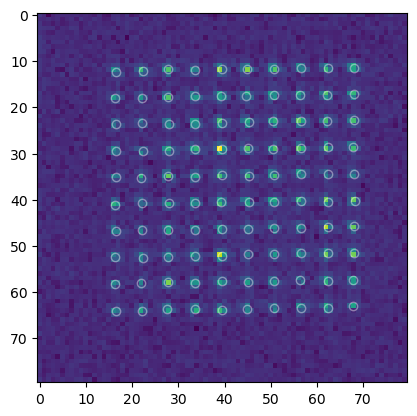

In [18]:
plt.imshow(np.mean(processor.fractional_stack(8), axis=0).T)
plt.plot(*positions.T, 'wo', fillstyle='none', alpha=0.4)

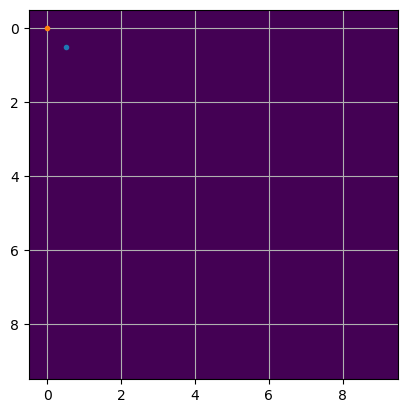

In [6]:
plt.imshow(np.zeros((10, 10)))
plt.plot(0.5, 0.5 , '.')
plt.plot(0, 0, '.')
plt.grid()

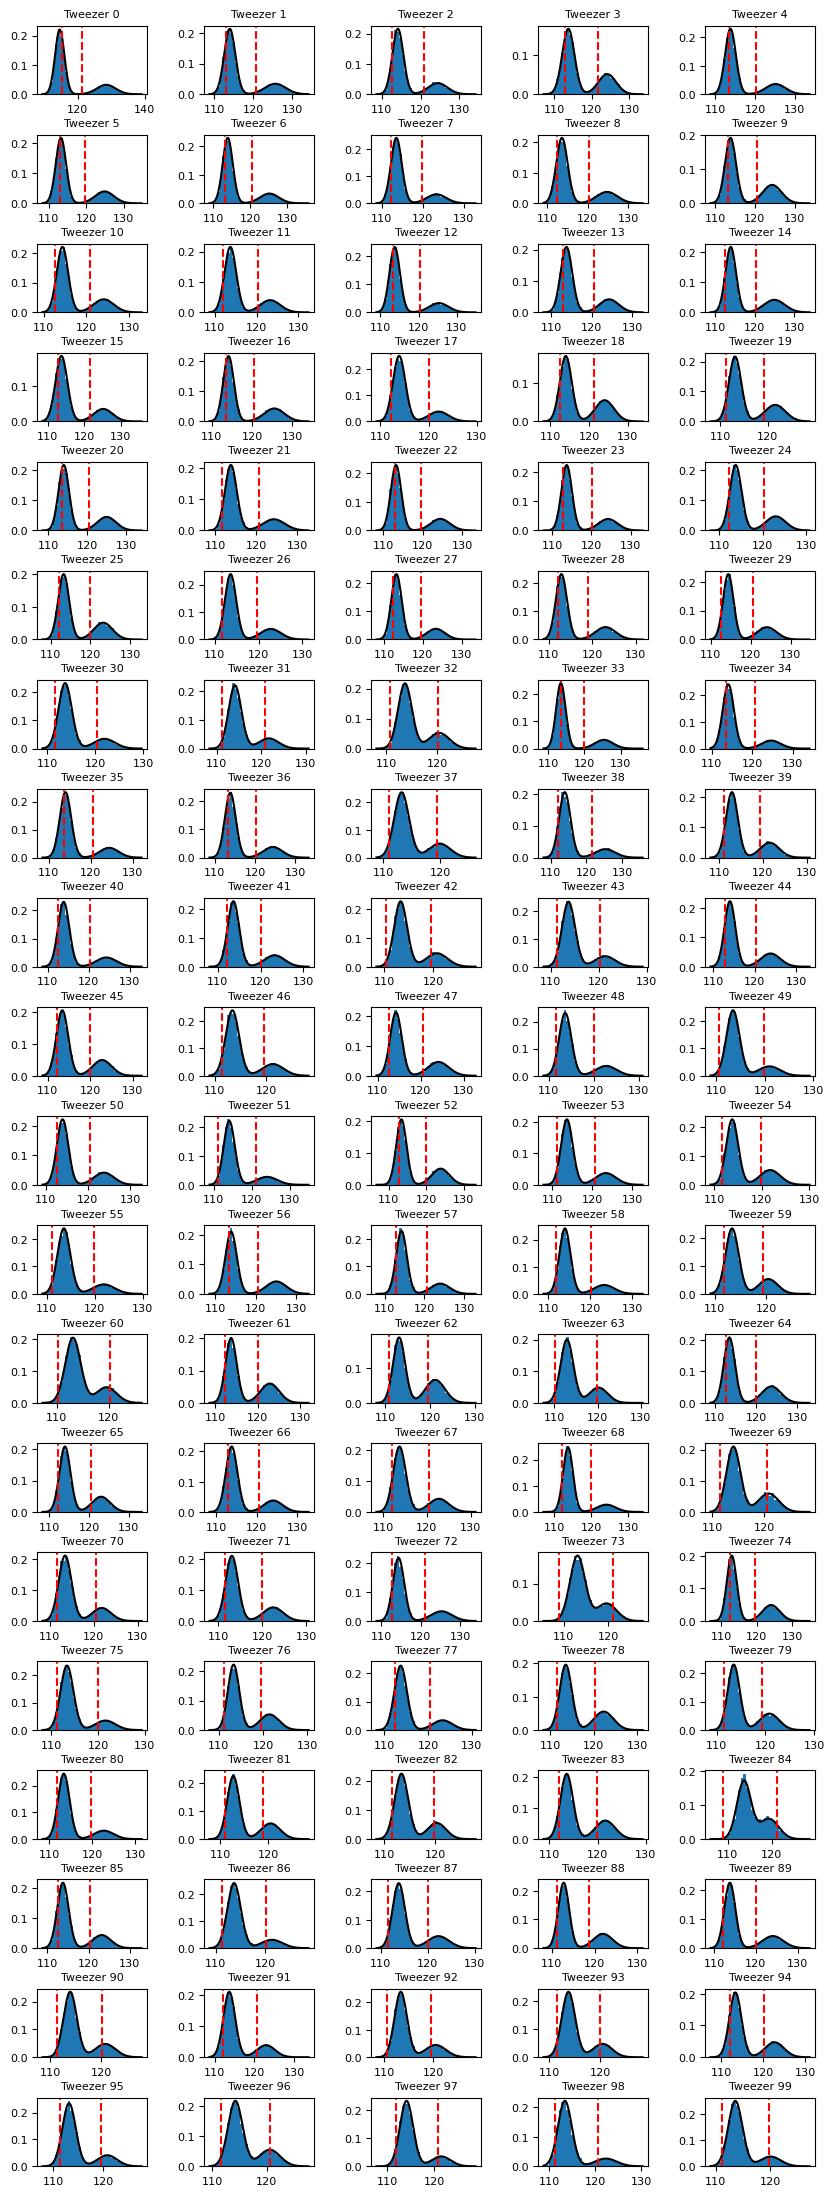

In [6]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

In [7]:
print(crops3x3.shape)
print(labels.shape)

(100, 15600, 16, 16)
(1560000,)


In [8]:
builder = DatasetBuilder.DatasetBuilder(crops3x3, labels)
training, testing, fidelity, info = builder.run()

In [9]:
print(labels.shape)

(1560000,)


In [10]:
trainer = ModelTrainer.ModelTrainer(model, training, testing, fidelity, 100, tot_loops, epochs=1)
model, info = trainer.run()

  695/37904 [..............................] - ETA: 2:25 - loss: 0.0066 - binary_accuracy: 0.9991

KeyboardInterrupt: 

In [ ]:
print(info)

In [ ]:
print(crops1x1.shape)

In [ ]:
plt.imshow(np.sum(crops1x1[1], axis=0))

In [ ]:
plt.plot(np.mean(crops1x1[1], axis=0)[3])

In [ ]:
import pdfkit
import matplotlib.pyplot as plt
import pandas as pd
from io import BytesIO

def convert_dict_to_pdf(data_dict, output_file):
    # Generate HTML content from the dictionary
    html_content = "<html><head><meta charset='UTF-8'></head><body>"
    for key, value in data_dict.items():
        # Check if the value is a matplotlib figure
        if isinstance(value, plt.Figure):
            # Convert the figure to bytes
            image_data = BytesIO()
            value.savefig(image_data, format='png')
            image_data.seek(0)

            # Embed the image in the HTML
            html_content += f"<h2>{key}</h2>"
            html_content += f'<img src="data:image/png;base64,{image_data.read().decode("utf-8")}" />'
        elif isinstance(value, pd.DataFrame):
            # Convert the DataFrame to HTML
            html_table = value.to_html()

            # Add the DataFrame HTML to the overall HTML content
            html_content += f"<h2>{key}</h2>"
            html_content += html_table
        else:
            html_content += f"<h2>{key}</h2>"
            html_content += f"<p>{value}</p>"
    html_content += "</body></html>"

    # Convert HTML to PDF with UTF-8 encoding
    options = {
        'encoding': 'UTF-8'
    }
    pdfkit.from_string(html_content, output_file, options=options)

# Example usage
my_dict = {
    'Name': 'John',
    'Age': 30,
    'City': 'New York',
    'Plot': plt.figure(),
    'Data': pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
}
# Plotting code
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]
plt.plot(x, y)
plt.title('Sample Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)

convert_dict_to_pdf(my_dict, 'output.pdf')


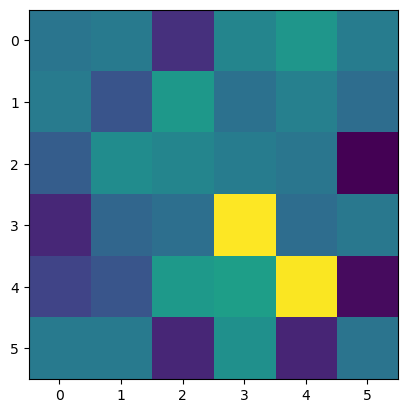

In [ ]:
plt.imshow(np.mean(crops1x1[49], axis=0))

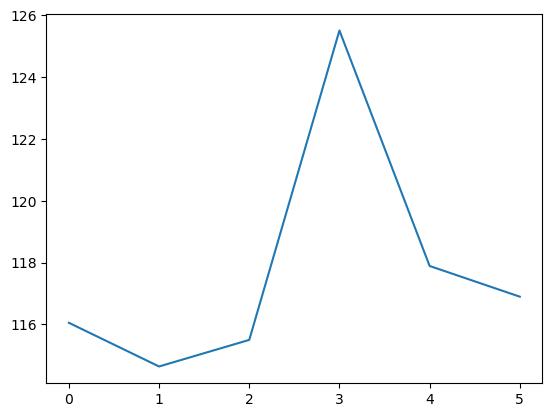

In [ ]:
plt.plot(np.mean(crops1x1[49], axis=0)[:,3])

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fit_gaussian_to_image(image_data):
    # Get image dimensions
    height, width = image_data.shape

    # Create coordinate grid
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    x = x.ravel()
    y = y.ravel()

    # Use the coordinates of the highest value data point as initial guess for mean
    max_index = np.argmax(image_data)
    initial_mean = (x.flatten()[max_index], y.flatten()[max_index])

    # Define the multivariate Gaussian function with offset and angle
    def gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, angle, offset):
        x, y = xy
        a = np.cos(angle)**2 / (2 * sigma_x**2) + np.sin(angle)**2 / (2 * sigma_y**2)
        b = -np.sin(2 * angle) / (4 * sigma_x**2) + np.sin(2 * angle) / (4 * sigma_y**2)
        c = np.sin(angle)**2 / (2 * sigma_x**2) + np.cos(angle)**2 / (2 * sigma_y**2)
        return amplitude * np.exp(
            - (a * (x - xo)**2) - (2 * b * (x - xo) * (y - yo)) - (c * (y - yo)**2)
        ) + offset

    # Set bounds for the fitting parameters
    bounds = (
        [0, 0, 0, 0, 0, -np.pi/4, -np.inf],   # Lower bounds
        [np.inf, width, height, np.inf, np.inf, np.pi/4, np.inf]  # Upper bounds
    )

    # Initial parameter guesses
    initial_params = (
        np.max(image_data),
        initial_mean[0],
        initial_mean[1],
        width / 10,
        height / 10,
        0,
        np.min(image_data)
    )

    print(image_data.shape)

    # Fit the Gaussian to the image data with bounds
    fitted_params, _ = curve_fit(gaussian, (x, y), image_data.flatten(), p0=initial_params, bounds=bounds)

    # Plot the fit
    #fitted_image = gaussian((x, y), *fitted_params)
    #plt.imshow(fitted_image, cmap='gray')
    #plt.colorbar()
    #plt.title('Gaussian Fit')
    #plt.show()

    return fitted_params

# Example usage
# Assume `image_data` is a 2D array containing the image pixel values
fitted_params = fit_gaussian_to_image(crops1x1[98].mean(axis=0))

# The fitted parameters include amplitude, xo, yo, sigma_x, sigma_y, angle, and offset
amplitude, xo, yo, sigma_x, sigma_y, angle, offset = fitted_params
print("Amplitude:", amplitude)
print("Center X-coordinate:", xo)
print("Center Y-coordinate:", yo)
print("Standard deviation in X-direction:", sigma_x)
print("Standard deviation in Y-direction:", sigma_y)
print("Angle between standard deviations:", angle)
print("Offset:", offset)


(6, 6)
Amplitude: 49.455094662049966
Center X-coordinate: 2.6396615933713083
Center Y-coordinate: 3.1651840162605724
Standard deviation in X-direction: 0.24024768877936356
Standard deviation in Y-direction: 0.6578789308031325
Angle between standard deviations: -0.21911538291511332
Offset: 113.78871969015655
